In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
sys.path.append('/home/amawi/projects/nn_ansatz/src')


In [2]:
import jax
from jax.tree_util import tree_flatten
from jax.experimental.optimizers import adam
import jax.numpy as jnp
from jax import lax, grad, pmap, vmap

import numpy as np
from tqdm.notebook import trange
from functools import partial

import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams.update({"font.family":"Times New Roman"})
from matplotlib import cm

from nn_ansatz import *

In [3]:
method = 'anisotropic'

cfg = config = setup(system='LiSolidBCC',
               n_pre_it=0,
               n_walkers=256,
               n_layers=2,
               n_sh=32,
               step_size=0.02,
               n_ph=8,
               orbital_decay=method,
               n_periodic_input=3,
               opt='adam',
               n_det=2,
               print_every=100,
               save_every=5000,
               n_it=10000)

logger = Logging(**cfg)

keys = rnd.PRNGKey(cfg['seed'])
if bool(os.environ.get('DISTRIBUTE')) is True:
    keys = rnd.split(keys, cfg['n_devices']).reshape(cfg['n_devices'], 2)

mol = SystemAnsatz(**cfg)

pwf = pmap(create_wf(mol), in_axes=(None, 0))
vwf = create_wf(mol)
jswf = jit(create_wf(mol, signed=True))
compute_ae_vectors = jit(partial(compute_ae_vectors_periodic_i, unit_cell_length=mol.unit_cell_length))
pwf_grad = grad(lambda x, y: pwf(x, y).sum(), argnums=(0,1))

sampler = create_sampler(mol, vwf)

ke = jit(create_local_kinetic_energy(vwf))
pe = jit(create_potential_energy(mol))
keep_in_boundary = jit(keep_in_boundary)

version 		 140921
seed 		 369
n_devices 		 1
save_every 		 5000
print_every 		 100
exp_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/100921_periodic/experiments/LiSolidBCC/140921/junk/adam_1lr-4_1d-3_1nc-4_m256_s32_p8_l2_det2/run2
events_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/100921_periodic/experiments/LiSolidBCC/140921/junk/adam_1lr-4_1d-3_1nc-4_m256_s32_p8_l2_det2/run2/events
models_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/100921_periodic/experiments/LiSolidBCC/140921/junk/adam_1lr-4_1d-3_1nc-4_m256_s32_p8_l2_det2/run2/models
opt_state_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/100921_periodic/experiments/LiSolidBCC/140921/junk/adam_1lr-4_1d-3_1nc-4_m256_s32_p8_l2_det2/run2/models/opt_state
pre_path 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/100921_periodic/experiments/LiSolidBCC/pretrained/s32_p8_l2_det2_1lr-4_i0.pk
timing_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/100921_peri

In [31]:
if method is 'anisotropic':
    path = '/home/amawi/projects/nn_ansatz/src/experiments/LiSolidBCC/100921/anisotropic/adam_1lr-4_1d-3_1nc-4_m256_s32_p8_l2_det2/run0/models'
else:
    path = '/home/amawi/projects/nn_ansatz/src/experiments/LiSolidBCC/100921/isotropic/adam_1lr-4_1d-3_1nc-4_m256_s32_p8_l2_det2/run0/models'

# params = initialise_params(mol, keys)
params = load_pk(os.path.join(path, 'i10000.pk'))
# walkers = initialise_walkers(mol, vwf, sampler, params, keys, walkers=None)
# save_pk(walkers, 'i10000_walkers.pk')
walkers = load_pk(os.path.join(path, 'i10000_walkers.pk'))
# walkers = np.random.uniform(0., 1., size=(1, 100, 6, 3)) * mol.unit_cell_length

In [32]:
print(walkers[0, 1])

[[3.3467538  3.065798   2.4722047 ]
 [5.2593527  5.8480663  4.7580996 ]
 [0.13456804 6.0300264  0.50579613]
 [5.3665876  0.45635793 5.593887  ]
 [3.3878782  3.1604102  4.2635355 ]
 [0.12787502 6.6001725  0.19215602]]


In [28]:
# LINE
n_points = 9999
assert n_points % 3 == 0
rx0, ry0, rz0 = np.array(mol.r_atoms[1, :])
X = np.linspace(rx0-1.5*mol.unit_cell_length, rx0+1.5*mol.unit_cell_length, n_points)

walker = np.array(walkers[:, 1, ...])
# walker[0, 0, -1] = rz0
# x_prime = np.linspace(rx0-0.5*mol.unit_cell_length, rx0+0.5*mol.unit_cell_length, n_points)
# p_up, p_down = 0.25, 0.75
# walker[0, 1] = np.array([x_prime[int(p_up*n_points)] for _ in range(3)])
# walker[0, 3] = np.array([X[int(p_up*n_points)] for _ in range(3)])
# idx = np.argmin(np.abs(X))
# X[idx] = 0.0

data = []
for i, x1 in enumerate(X):
    
    walker[0, 0] = jnp.array([[x1, x1, x1]])
    jwalker = jnp.array(walker)
    jwalker = keep_in_boundary(jwalker, mol.real_basis, mol.inv_real_basis)
    jx, jy, jz = jwalker[0, 0]

    # ae_vectors = spline(jwalker, mol.r_atoms, mol.unit_cell_length)
    # mask = jnp.isinf(ae_vectors) 
    # max_ninf = mask.sum(-1).max()

    log_psi, sign = jswf(params, jwalker)
    amplitude = sign * jnp.exp(log_psi)
    probability = amplitude**2
    
    potential_energy = pe(jwalker, mol.r_atoms, mol.z_atoms)
    kinetic_energy = ke(params, jwalker)
    local_energy = potential_energy + kinetic_energy
    gparam, gwalker = pwf_grad(params, walkers)
    gwx, gwy, gwz = gwalker[0, 0, 0, :]
    
    tmp = [x1, x1, x1, jx, jy, jz, 
           amplitude.mean(), probability.mean(), local_energy.mean(), potential_energy.mean(), kinetic_energy.mean(),
           gwx, gwy, gwz]

    data.append(tmp)
    print('row %i' % (i+1), ' / %i' % n_points)

data = np.array(data)
data = pd.DataFrame(data, columns=['y', 'x', 'z', 'jx', 'jy', 'jz', \
                                   'amps', 'probs', 'local_e', 'potential_e', 'kinetic_e', \
                                   'gwx', 'gwy', 'gwz'])

data_flat = data.copy()
variables = ['amps', 'probs', 'local_e', 'potential_e', 'kinetic_e']
lb, rb = rx0-0.5*mol.unit_cell_length, rx0+0.5*mol.unit_cell_length
for variable in variables:
    llocs = data['x']<=lb
    rlocs = data['x']>=rb
    locs = llocs | rlocs
    tmp = pd.concat([data[variable].loc[~locs], data[variable].loc[~locs]])
    data_flat[variable].loc[locs] -= tmp.values

row 1  / 9999
row 2  / 9999
row 3  / 9999
row 4  / 9999
row 5  / 9999
row 6  / 9999
row 7  / 9999
row 8  / 9999
row 9  / 9999
row 10  / 9999
row 11  / 9999
row 12  / 9999
row 13  / 9999
row 14  / 9999
row 15  / 9999
row 16  / 9999
row 17  / 9999
row 18  / 9999
row 19  / 9999
row 20  / 9999
row 21  / 9999
row 22  / 9999
row 23  / 9999
row 24  / 9999
row 25  / 9999
row 26  / 9999
row 27  / 9999
row 28  / 9999
row 29  / 9999
row 30  / 9999
row 31  / 9999
row 32  / 9999
row 33  / 9999
row 34  / 9999
row 35  / 9999
row 36  / 9999
row 37  / 9999
row 38  / 9999
row 39  / 9999
row 40  / 9999
row 41  / 9999
row 42  / 9999
row 43  / 9999
row 44  / 9999
row 45  / 9999
row 46  / 9999
row 47  / 9999
row 48  / 9999
row 49  / 9999
row 50  / 9999
row 51  / 9999
row 52  / 9999
row 53  / 9999
row 54  / 9999
row 55  / 9999
row 56  / 9999
row 57  / 9999
row 58  / 9999
row 59  / 9999
row 60  / 9999
row 61  / 9999
row 62  / 9999
row 63  / 9999
row 64  / 9999
row 65  / 9999
row 66  / 9999
row 67  / 9999
row 

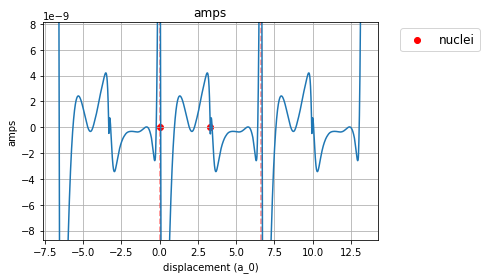

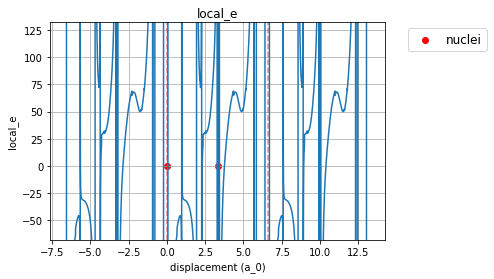

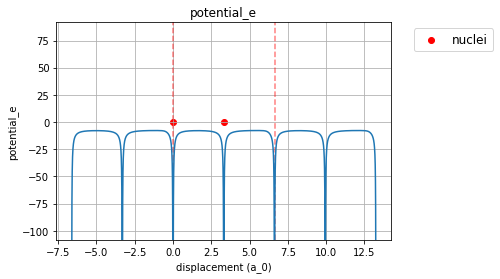

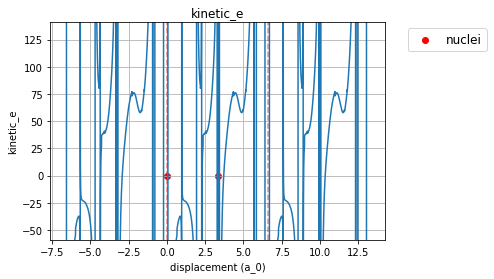

In [30]:
import matplotlib as mpl
import matplotlib.font_manager
# mpl.rcParams['font.family'] = ['serif']
# mpl.rcParams['font.serif'] = ['Times New Roman']

def set_lims(ax, data):
    data = np.where(np.isnan(data), 0.0, data)
    data = np.where(np.isinf(data), np.sign(data) * 10000., data)
    std = np.std(data)
    median = np.median(data)
    bound = 100.
    ax.set_ylim(np.max([median - std, median-bound]), np.min([median + std, median+bound]))
    # are_negative = (data < 0.0).any()
    # if are_negative:
    #     median_negative = np.median(data[data < 0.0])
    #     ymin = 4 * median_negative
    # else:
    #     ymin = 0.
    # median_positive = np.median(data[data > 0.0])
    # ax.set_ylim(ymin, median_positive * 5.)

def pretty_base(title=None, 
                xaxis=None, 
                yaxis=None, 
                xlims=None, 
                ylims=None,
                legend=None,
                figsize=(4,4),
                xlines=[],
                ylines=[]):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    csfont = {'fontname':'Comic Sans MS'}
    hfont = {'fontname':'Helvetica'}

    ax.set_title(title) #, **csfont)
    ax.set_xlabel(xaxis) #, **hfont)
    ax.set_ylabel(yaxis)
    if legend is None:
        pass
    elif legend is 'outside':
        ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    elif legend is 'inside':
        ax.legend(fontsize=12)
    if xlims is not None: ax.set_xlim(xlims) 
    if ylims is not None: ax.set_ylim(ylims)
    ax.grid(b=True, which='major', axis='both')
    [ax.axhline(y=x, ls='--') for x in xlines]
    [ax.axvline(x=y, ls='--', alpha=0.5, color='r') for y in ylines]
    return fig, ax

walker = keep_in_boundary(jnp.array(walker), mol.real_basis, mol.inv_real_basis)

names = ['amps', 'local_e', 'potential_e', 'kinetic_e']



for name in names:
    plot_data = data[name][1:-2]
    fig, ax = pretty_base(title=name, 
                          figsize=(6, 4), 
                          xaxis='displacement (a_0)', 
                          yaxis=name, 
                          ylines=[rx0-0.5*mol.unit_cell_length, rx0+0.5*mol.unit_cell_length])

    # plot_data = data[name]
    ax.plot(X[1:-2], plot_data)

    ax.scatter(mol.r_atoms[:, 0], [0., 0.], color='r', label='nuclei')
    # ax.scatter(walker[0, 1, 0], [0.0,], color='b', label='e_up (same spin)')
    # ax.scatter(walker[0, 3, 0], [0.0,], color='g', label='e_down (diff spin)')
    
    # ax.scatter(walker[0, 1, 0], walker[0, 1, 1], color='g')
    # ax.scatter(walker[0, 3, 0], walker[0, 3, 1], color='g')
    set_lims(ax, plot_data)
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

    # plt.show()
    # cb = fig.colorbar(p, ax=ax)
    # fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (kappa, plot_data.min().min(), plot_data.max().max()))
# fig.tight_layout()
plt.savefig('line_electron_sweep.png', facecolor='white', transparent=False)
plt.show()

In [ ]:
print(walker)

333    458.374603
334    284.876587
335    303.204742
336    354.280945
337    498.116241
          ...    
661     96.774902
662    120.406998
663    149.749512
664    191.988647
665    402.565857
Name: kinetic_e, Length: 666, dtype: float64
0      4.646560e+06
1      2.953994e+02
2      2.917905e+02
3      3.367730e+02
4               NaN
           ...     
994    1.040395e+02
995    1.294946e+02
996    1.613622e+02
997    2.172732e+02
998    1.925470e+06
Name: kinetic_e, Length: 666, dtype: float64


In [ ]:
@jit
def spline(walker, r_atoms, unit_cell_length):
    ae_vector = compute_ae_vectors(walker, r_atoms)
    ae_vector = jnp.where(ae_vector < -0.25 * unit_cell_length, -unit_cell_length**2/(8.*(unit_cell_length + 2.*ae_vector)), ae_vector)
    ae_vector = jnp.where(ae_vector > 0.25 * unit_cell_length, unit_cell_length**2/(8.*(unit_cell_length - 2.*ae_vector)), ae_vector)
    return ae_vector

spline = vmap(spline, in_axes=(0, None, None))

In [ ]:
# PLANE

# jwalker.shape (1, 6, 3)
# r_atoms.shape (2, 3)
walker = np.array(walkers[:, 0, ...])
rx0, ry0, rz0 = np.array(mol.r_atoms[1, :])
walker[0, 0, -1] = rz0
walker[0, 1, -1] = rz0
walker[0, 3, -1] = rz0

n_points = 100
X = np.linspace(rx0-1.5*mol.unit_cell_length, rx0+1.5*mol.unit_cell_length, n_points)
# idx = np.argmin(np.abs(X))
# X[idx] = 0.0

print(rz0)

data = []
for i, y1 in enumerate(X):
    for x1 in X:
        walker[0, 0] = jnp.array([[x1, y1, rz0]])
        jwalker = jnp.array(walker)

        # print(jwalker.shape, mol.r_atoms.shape)

        # ae_vectors = spline(jwalker, mol.r_atoms, mol.unit_cell_length)
        # mask = jnp.isinf(ae_vectors) 
        # max_ninf = mask.sum(-1).max()

        jwalker = keep_in_boundary(jwalker, mol.real_basis, mol.inv_real_basis)
        log_psi, sign = jswf(params, jwalker)
        amplitude = sign * jnp.exp(log_psi)
        probability = amplitude**2
        
        potential_energy = pe(jwalker, mol.r_atoms, mol.z_atoms)
        kinetic_energy = ke(params, jwalker)
        local_energy = potential_energy + kinetic_energy
        tmp = [y1, x1, amplitude.mean(), probability.mean(), local_energy.mean(), potential_energy.mean(), kinetic_energy.mean()]
        data.append(tmp)
    print('row %i' % (i+1), ' / %i' % n_points)

data = np.array(data)
data = pd.DataFrame(data, columns=['y', 'x', 'amps', 'probs', 'local_e', 'potential_e', 'kinetic_e'])


save_pk(data, 'electron_sweep1.pk')
print(data)

In [ ]:
XX, YY = np.meshgrid(X, X)

fig, axs = plt.subplots(3, 2, figsize=(14,14))
axs = [x for y in axs for x in y]

names = ['amps', 'local_e', 'potential_e', 'kinetic_e', 'max_ninf']

for ax, name in zip(axs, names):
    plot_data = data.pivot(index='x', columns='y', values=name).values
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)
    
    cmap = cm.get_cmap('cool', 3) if name is 'max_ninf' else cm.cool
    if name is not 'max_ninf':
        vmin, vmax = plot_data.min().min(), plot_data.max().max()  
    else:
        vmin, vmax = 0.5, 3.5
    
    plot_data = data.pivot(index='x', columns='y', values=name).values
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)
    p = ax.pcolor(XX, YY, plot_data, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    ax.scatter(mol.r_atoms[:, 0], mol.r_atoms[:, 1], color='r')
    ax.scatter(walker[0, 1, 0], walker[0, 1, 1], color='g')
    ax.scatter(walker[0, 3, 0], walker[0, 3, 1], color='g')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(name)
    cb = fig.colorbar(p, ax=ax)
    # fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (kappa, plot_data.min().min(), plot_data.max().max()))
fig.tight_layout()
plt.savefig('electron_sweep.png', facecolor='white', transparent=False)
plt.show()

In [10]:
# LINE

walker = np.array(walkers[:, 0, ...])
rx0, ry0, rz0 = np.array(mol.r_atoms[1, :])
# walker[0, 0, -1] = rz0
# walker[0, 1, -1] = rz0
# walker[0, 3, -1] = rz0

n_points = 100
X = np.linspace(rx0-1.5*mol.unit_cell_length, rx0+1.5*mol.unit_cell_length, n_points)

n_points = 100
X = np.linspace(rx0-mol.unit_cell_length, rx0+mol.unit_cell_length, n_points)

walker = np.array(walkers[:, 0, ...])
rx0, ry0, rz0 = np.array(mol.r_atoms[1, :])
walker[0, 0, -1] = rz0
walker[0, 1] = np.array([X[45] for _ in range(3)])
walker[0, 3] = np.array([X[60] for _ in range(3)])


# idx = np.argmin(np.abs(X))
# X[idx] = 0.0

print(rz0)

data = []
for i, x1 in enumerate(X):
    
    walker[0, 0] = jnp.array([[x1, x1, x1]])
    jwalker = jnp.array(walker)

    # print(jwalker.shape, mol.r_atoms.shape)

    jwalker = keep_in_boundary(jwalker, mol.real_basis, mol.inv_real_basis)
    jx, jy, jz = jwalker[0, 0]

    ae_vectors = spline(jwalker, mol.r_atoms, mol.unit_cell_length)
    mask = jnp.isinf(ae_vectors) 
    max_ninf = mask.sum(-1).max()

    log_psi, sign = jswf(params, jwalker)
    amplitude = sign * jnp.exp(log_psi)
    probability = amplitude**2
    
    potential_energy = pe(jwalker, mol.r_atoms, mol.z_atoms)
    kinetic_energy = ke(params, jwalker)
    local_energy = potential_energy + kinetic_energy
    tmp = [x1, x1, x1, jx, jy, jz, amplitude.mean(), probability.mean(), local_energy.mean(), potential_energy.mean(), kinetic_energy.mean(), max_ninf]
    data.append(tmp)
    print('row %i' % (i+1), ' / %i' % n_points)

data = np.array(data)
data = pd.DataFrame(data, columns=['y', 'x', 'z', 'jx', 'jy', 'jz', 'amps', 'probs', 'local_e', 'potential_e', 'kinetic_e', 'max_ninf'])
variables = ['amps', 'probs', 'local_e', 'potential_e', 'kinetic_e']
lb, rb = rx0-0.5*mol.unit_cell_length, rx0+0.5*mol.unit_cell_length
for variable in variables:
    llocs = data['x']<lb
    rlocs = data['x']>rb
    locs = llocs or rlocs
    tmp = data[variable].loc[~locs]
    data.loc[locs, '%s'%variable] -= tmp

print(data)

TypeError: unhashable type: 'slice'

(1, 6, 3)


ValueError: Axis limits cannot be NaN or Inf

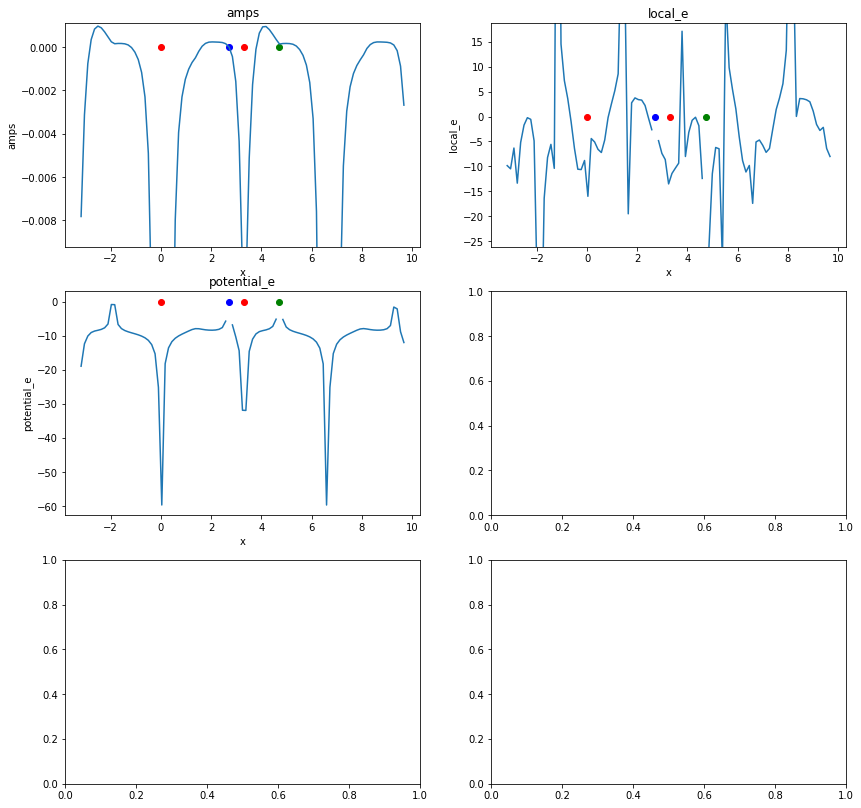

In [17]:
XX, YY = np.meshgrid(X, X)
print(walker.shape)

def set_lims(ax, data):
    are_negative = (data < 0.0).any()
    if are_negative:
        median_negative = np.median(data[data < 0.0])
        ymin = 4 * median_negative
    else:
        ymin = 0.
    median_positive = np.median(data[data > 0.0])
    ax.set_ylim(ymin, median_positive * 5.)
    
fig, axs = plt.subplots(3, 2, figsize=(14,14))
axs = [x for y in axs for x in y]

walker = keep_in_boundary(jnp.array(walker), mol.real_basis, mol.inv_real_basis)

names = ['amps', 'local_e', 'potential_e', 'kinetic_e', 'max_ninf', 'jx']

for ax, name in zip(axs, names):
    
    # cmap = cm.get_cmap('cool', 3) if name is 'max_ninf' else cm.cool
    # if name is not 'max_ninf':
    #     vmin, vmax = plot_data.min().min(), plot_data.max().max()  
    # else:
    #     vmin, vmax = 0.5, 3.5
    
    plot_data = data[name][1:-2]
    # plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)
    ax.plot(X[1:-2], plot_data)

    ax.scatter(mol.r_atoms[:, 0], [0., 0.], color='r')
    ax.scatter(walker[0, 1, 0], [0.0,], color='b')
    ax.scatter(walker[0, 3, 0], [0.0,], color='g')
    
    # ax.scatter(walker[0, 1, 0], walker[0, 1, 1], color='g')
    # ax.scatter(walker[0, 3, 0], walker[0, 3, 1], color='g')
    ax.set_xlabel('x')
    ax.set_ylabel(name)
    ax.set_title(name)
    set_lims(ax, plot_data)
    # cb = fig.colorbar(p, ax=ax)
    # fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (kappa, plot_data.min().min(), plot_data.max().max()))
fig.tight_layout()
plt.savefig('line_electron_sweep.png', facecolor='white', transparent=False)
plt.show()

In [18]:
print(data[1:-2])

           y         x         z        jx        jy        jz      amps  \
1  -3.181061 -3.181061 -3.181061  3.448940  3.448940  3.448940 -0.007817   
2  -3.047121 -3.047121 -3.047121  3.582879  3.582879  3.582879 -0.003131   
3  -2.913182 -2.913182 -2.913182  3.716819  3.716819  3.716819 -0.000760   
4  -2.779242 -2.779242 -2.779242  3.850758  3.850758  3.850758  0.000347   
5  -2.645303 -2.645303 -2.645303  3.984697  3.984697  3.984697  0.000832   
..       ...       ...       ...       ...       ...       ...       ...   
93  9.141364  9.141364  9.141364  2.511364  2.511364  2.511364  0.000192   
94  9.275303  9.275303  9.275303  2.645302  2.645302  2.645302  0.000098   
95  9.409242  9.409242  9.409242  2.779242  2.779242  2.779242 -0.000164   
96  9.543182  9.543182  9.543182  2.913181  2.913181  2.913181 -0.000879   
97  9.677121  9.677121  9.677121  3.047121  3.047121  3.047121 -0.002679   

           probs    local_e  potential_e  kinetic_e  max_ninf  
1   6.110154e-05  -9.84